In [309]:
import kagglehub
import glob
import os
import pandas as pd
import numpy as np
#from scipy.special import integer
from ucimlrepo import fetch_ucirepo 
from sklearn import svm
from tqdm import tqdm
from skopt import BayesSearchCV

from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram
from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,  GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier

import openml
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from scipy.stats import uniform, randint
import random
import csv
import ast
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import loguniform

### Wczytywanie danych

In [310]:
path_banana = kagglehub.dataset_download("l3llff/banana")
path_credit = kagglehub.dataset_download("rohitudageri/credit-card-details")

In [311]:
full_path_banana = glob.glob(os.path.join(path_banana, '*.csv')) # zawsze dobre wyniki
df_banana = pd.read_csv(full_path_banana[0])

X_banana = df_banana.drop('Quality', axis=1)
y_banana = df_banana.Quality

y_banana = y_banana.map({'Good': 1, 'Bad': 0})

In [312]:
X_credit = pd.read_csv(f"{path_credit}/Credit_card.csv") # nie zbalansowany ale git
y_credit = pd.read_csv(f"{path_credit}/Credit_card_label.csv").label

In [313]:
dataset = openml.datasets.get_dataset(847)

X, _, _, _ = dataset.get_data(dataset_format="dataframe")
X['binaryClass'] = X['binaryClass'].map({'P': 1, 'N': 0})
y_wind = X.loc[:, 'binaryClass']
X_wind = X.drop(['binaryClass'], axis = 1)

In [314]:
dataset = openml.datasets.get_dataset(846)

X, _, _, _ = dataset.get_data(dataset_format="dataframe")
X['binaryClass'] = X['binaryClass'].map({'P': 1, 'N': 0})
X = X.sample(n=5000, random_state=123)
y_elevators = X.loc[:, 'binaryClass']
X_elevators= X.drop(['binaryClass'], axis = 1)

In [315]:
names_list = ['banana', 'credit', 'wind', 'elevators']
feature_list = [X_banana, X_credit, X_wind, X_elevators]
target_list = [y_banana, y_credit, y_wind, y_elevators]
dict = {key: {
    "X": None,
    "y": None,
    "search_results": None,
    "bayes_results": None,
    "basic_score": None,
    "search_score": None,
    "bayes_score": None,
    "search_results_1":None,
    "search_results_2":None,
    "search_results_3":None,
    "search_results_4":None,
    "search_results_5":None,
    "search_results_6":None,
    "search_results_7":None,
    "cv_1":None,
    "cv_2":None,
    "cv_3":None,
    "cv_4":None,
    "cv_5":None,
    "cv_6":None,
    "cv_7":None
} for key in names_list}

for name, X, y in zip(names_list, feature_list, target_list):
    dict[name]["X"] = X
    dict[name]["y"] = y

In [316]:
banana_class_1 = y_banana[y_banana == 1].count() / len(y_banana) * 100
credit_class_1 = y_credit[y_credit == 1].count() / len(y_credit) * 100
wind_class_1 = y_wind[y_wind == 1].count() / len(y_wind) * 100
elevators_class_1 = y_elevators[y_elevators == 1].count() / len(y_elevators) * 100

In [317]:
print({'banana': round(banana_class_1), 'credit': round(credit_class_1), 'wind': round(wind_class_1), 'elevators': round(elevators_class_1)})

{'banana': 50, 'credit': 11, 'wind': 53, 'elevators': 69}


# Przygotowanie modeli

In [318]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('scale', MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


col_trans = ColumnTransformer([
    ('num_pipeline', num_pipeline, make_column_selector(dtype_include = np.number)),
    ('cat_pipeline', cat_pipeline, make_column_selector(dtype_include = np.object_))
])


In [319]:
svm_pipeline = Pipeline([('preprocessing', col_trans),    
                           ('feature_selection', SelectFromModel(RandomForestClassifier())),
                           ('model', svm.SVC())])

knn_pipeline = Pipeline([
    ('preprocess', col_trans),
    ('feature_selection', SelectFromModel(RandomForestClassifier())),
    ('model', KNeighborsClassifier())
])

gb_pipeline = Pipeline([
    ('preprocess', col_trans),
    ('feature_selection', SelectFromModel(RandomForestClassifier())),
    ('model', GradientBoostingClassifier())
])

scoring = 'roc_auc'
n_cv_folds = 3


# Gradient Boosting

In [320]:
n_estimators = randint(100, 500)
learning_rate =uniform(loc=0.001, scale=0.999)
subsample = uniform(loc = 0.1, scale = 0.9)
max_depth = randint(4, 10)

parameters = {
    'model__n_estimators' : n_estimators, 
    'model__learning_rate' : learning_rate, 
    'model__subsample' : subsample,
    'model__max_depth' : max_depth
}

In [321]:
for key in tqdm(dict.keys(), desc="Processing keys"):

    X = dict[key]["X"]
    y = dict[key]["y"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    basic_model = gb_pipeline.fit(X_train, y_train)
    y_pred_basic = basic_model.predict(X_test)

    grid = RandomizedSearchCV(estimator=gb_pipeline, 
                                param_distributions=parameters, 
                                n_iter=150, 
                                random_state=0, 
                                n_jobs=-1, 
                                cv=n_cv_folds, 
                                scoring=scoring)
    
    grid.fit(X_train, y_train)
    y_pred_grid = grid.predict(X_test)

    dict[key]["search_results"] = grid
    dict[key]["basic_score"] = roc_auc_score(y_test, y_pred_basic)
    dict[key]["search_score"] = roc_auc_score(y_test, y_pred_grid)
    

Processing keys: 100%|██████████| 4/4 [08:31<00:00, 127.84s/it]


In [322]:
gb_parameters = {
    'model__n_estimators' : Integer(100, 500), 
    'model__learning_rate' : Real(0.001, 1.0), 
    'model__subsample' : Real(0.1, 1.0),
    'model__max_depth' : Integer(4, 10)
}

In [323]:
for key in tqdm(dict.keys(), desc="Processing keys"):

    X = dict[key]["X"]
    y = dict[key]["y"]
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    bayes = BayesSearchCV(
        gb_pipeline,
        gb_parameters,
        n_iter=150,
        cv=n_cv_folds,
        n_jobs=-1,
        random_state=0,
        scoring=scoring
)
        
    bayes.fit(X_train, y_train)
    y_pred_bayes = bayes.predict(X_test)
        
    dict[key]["bayes_results"] = bayes
    dict[key]["bayes_score"] = roc_auc_score(y_test, y_pred_bayes) 

Processing keys: 100%|██████████| 4/4 [52:07<00:00, 781.77s/it]


In [324]:
for key in dict.keys():
    print(f"{key} rs best cv score: {dict[key]['search_results'].best_score_}")
    print(f"{key} rs best params: {dict[key]['search_results'].best_params_}")
    print(f"{key} bayes best cv score: {dict[key]['bayes_results'].best_score_}")
    print(f"{key} bayes best params: {dict[key]['bayes_results'].best_params_}")
    
# TODO: zmienic na tabelke

banana rs best cv score: 0.9859650362171011
banana rs best params: {'model__learning_rate': 0.06508334885243558, 'model__max_depth': 6, 'model__n_estimators': 327, 'model__subsample': 0.8785923051748464}
banana bayes best cv score: 0.9902817705530681
banana bayes best params: OrderedDict([('model__learning_rate', 0.23941969605875246), ('model__max_depth', 10), ('model__n_estimators', 100), ('model__subsample', 1.0)])
credit rs best cv score: 0.7449696193061475
credit rs best params: {'model__learning_rate': 0.11708570770278201, 'model__max_depth': 9, 'model__n_estimators': 477, 'model__subsample': 0.4568551667622862}
credit bayes best cv score: 0.751614027017418
credit bayes best params: OrderedDict([('model__learning_rate', 0.2035144452155986), ('model__max_depth', 10), ('model__n_estimators', 500), ('model__subsample', 0.48859723639228236)])
wind rs best cv score: 0.9186970352640502
wind rs best params: {'model__learning_rate': 0.017312174181024185, 'model__max_depth': 4, 'model__n_e

In [325]:
for key in dict.keys():
    print(f"{key} basic test score: {dict[key]['basic_score']}")
    print(f"{key} rs test score: {dict[key]['search_score']}")
    print(f"{key} bayes test score: {dict[key]['bayes_score']}")

banana basic test score: 0.9293194617197218
banana rs test score: 0.9718312280065754
banana bayes test score: 0.9255598752429823
credit basic test score: 0.6267532467532467
credit rs test score: 0.7212987012987012
credit bayes test score: 0.7355844155844156
wind basic test score: 0.8257766174612213
wind rs test score: 0.8234401688630905
wind bayes test score: 0.8236449986807571
elevators basic test score: 0.8042652027027029
elevators rs test score: 0.8248234029484028
elevators bayes test score: 0.8270500614250614


In [326]:
scores_sum = {}
for key in dict.keys():
    for param in dict[key]['search_results'].cv_results_['params']:
        score = dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(param)]
        if str(param) in scores_sum:
            scores_sum[str(param)] += float(score)
        else:
            scores_sum[str(param)] = float(score)

best_params = max(scores_sum, key=scores_sum.get)
best_params = ast.literal_eval(best_params)

for key in dict.keys():
    
    tunability = dict[key]['search_results'].best_score_ -  dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(best_params)]
    print(f"{key} tunability: {tunability}")

banana tunability: 0.010831150931346456
credit tunability: 0.0
wind tunability: 0.01308462757635942
elevators tunability: 0.008422500407686218


In [327]:
print(best_params)

{'model__learning_rate': 0.11708570770278201, 'model__max_depth': 9, 'model__n_estimators': 477, 'model__subsample': 0.4568551667622862}


In [328]:
tunability = [dict[key]['search_results'].best_score_ - dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(best_params)] for key in dict.keys()]

with open('tunability_boost.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in tunability:
        writer.writerow([value])

In [329]:
data = {}

for key in dict.keys():
    split_test_score_list = []
    
    for i in range(n_cv_folds): 
        split_scores = dict[key]['search_results'].cv_results_[f"split{i}_test_score"].tolist()
        split_test_score_list += split_scores 
    
    data[key] = split_test_score_list

df_scores = pd.DataFrame(data)
df_scores.to_csv('dane/boost_scores.csv', index=False)

In [330]:
iteration_scores = [dict[key]["bayes_results"].cv_results_['mean_test_score'] for key in dict.keys()]
df_scores.to_csv('dane/boost_iterations.csvrations.csv', index=False) 

    

In [331]:
print(iteration_scores)

[array([0.96000257, 0.98006598, 0.90127073, 0.97097967, 0.91662562,
       0.69246795, 0.74679524, 0.6724469 , 0.96232788, 0.9714911 ,
       0.94015661, 0.97681726, 0.94474114, 0.97351944, 0.97806044,
       0.96717361, 0.97820465, 0.94548391, 0.9639438 , 0.96741176,
       0.97904469, 0.97093427, 0.97656458, 0.96833568, 0.96820928,
       0.92749215, 0.97777698, 0.95958827, 0.96991751, 0.97852843,
       0.98306885, 0.95322803, 0.95033131, 0.96215373, 0.96627805,
       0.98416343, 0.96760373, 0.97907064, 0.9452341 , 0.98014338,
       0.94113262, 0.96852482, 0.96852473, 0.97679139, 0.96267723,
       0.96518116, 0.95635604, 0.94700877, 0.9827804 , 0.96966368,
       0.96577437, 0.88751988, 0.97072562, 0.93616356, 0.79067323,
       0.98076025, 0.95945982, 0.96645032, 0.97119647, 0.95785176,
       0.65300874, 0.97985989, 0.98409979, 0.9730623 , 0.97072709,
       0.99028177, 0.96036154, 0.95761897, 0.95360152, 0.97004346,
       0.96124192, 0.97605167, 0.96169023, 0.97272963, 0.9746

In [332]:
gb_scores_banana_search = dict['banana']["search_results"].cv_results_['mean_test_score']
gb_scores_banana_bayes = dict['banana']["bayes_results"].cv_results_['mean_test_score']
gb_scores_wind_search = dict['wind']["search_results"].cv_results_['mean_test_score']
gb_scores_wind_bayes = dict['wind']["bayes_results"].cv_results_['mean_test_score']
gb_scores_credit_search = dict['credit']["search_results"].cv_results_['mean_test_score']
gb_scores_credit_bayes = dict['credit']["bayes_results"].cv_results_['mean_test_score']
gb_scores_elevators_search = dict['elevators']["search_results"].cv_results_['mean_test_score']
gb_scores_elevators_bayes = dict['elevators']["bayes_results"].cv_results_['mean_test_score']

def not_descending_list(a):
    for i in range(1,len(a)):
        a[i] = max(a[i], a[i-1])

not_descending_list(gb_scores_banana_search)
not_descending_list(gb_scores_banana_bayes)
not_descending_list(gb_scores_wind_search)
not_descending_list(gb_scores_wind_bayes)
not_descending_list(gb_scores_credit_search)
not_descending_list(gb_scores_credit_bayes)
not_descending_list(gb_scores_elevators_search)
not_descending_list(gb_scores_elevators_bayes)

# SVM

In [333]:
from scipy.stats import loguniform

C_values = uniform(loc=0.001, scale=(1000-0.001))
gamma_values = uniform(loc = 0.001, scale = (1000-0.001))


parameters_svm = {
    'model__C' : C_values, 
    'model__gamma' : gamma_values
}

for key in tqdm(dict.keys(), desc="Processing keys"):

    X = dict[key]["X"]
    y = dict[key]["y"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    basic_model = svm_pipeline.fit(X_train, y_train)
    y_pred_basic = basic_model.predict(X_test)
    

    random_svm = RandomizedSearchCV(estimator=svm_pipeline, 
                                    param_distributions=parameters_svm, 
                                    n_iter=150, 
                                    random_state=0, 
                                    n_jobs=-1, 
                                    cv=n_cv_folds, 
                                    scoring=scoring)
        
    random_svm.fit(X_train, y_train)
    y_pred = random_svm.predict(X_test)

    dict[key]["search_results"] = random_svm
    dict[key]["basic_score"] = roc_auc_score(y_test, y_pred_basic)
    dict[key]["search_score"] = roc_auc_score(y_test, y_pred)


Processing keys: 100%|██████████| 4/4 [04:18<00:00, 64.53s/it] 


In [334]:
for key in dict.keys():
    print(f"{key} grid best cv score: {dict[key]['search_results'].best_score_}")
    print(f"{key} grid best params: {dict[key]['search_results'].best_params_}")

banana grid best cv score: 0.9751202152537237
banana grid best params: {'model__C': 729.9908324334956, 'model__gamma': 171.63050563176327}
credit grid best cv score: 0.7185539598529999
credit grid best params: {'model__C': 64.14843220128802, 'model__gamma': 692.4724268979005}
wind grid best cv score: 0.9045647448898942
wind grid best params: {'model__C': 828.9402002773339, 'model__gamma': 4.696471497070873}
elevators grid best cv score: 0.9012807620780546
elevators grid best params: {'model__C': 828.9402002773339, 'model__gamma': 4.696471497070873}


In [335]:
for key in dict.keys():
    print(f"{key} basic test score: {dict[key]['basic_score']}")
    print(f"{key} Random Search test score: {dict[key]['search_score']}")

banana basic test score: 0.9599039945996961
banana Random Search test score: 0.9055118725428306
credit basic test score: 0.5
credit Random Search test score: 0.6927272727272726
wind basic test score: 0.824746682219846
wind Random Search test score: 0.8254896242703661
elevators basic test score: 0.8242475429975431
elevators Random Search test score: 0.8202357186732187


In [336]:
scores_sum = {}
for key in dict.keys():
    for param in dict[key]['search_results'].cv_results_['params']:
        score = dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(param)]
        if str(param) in scores_sum:
            scores_sum[str(param)] += float(score)
        else:
            scores_sum[str(param)] = float(score)

best_params = max(scores_sum, key=scores_sum.get)
best_params = ast.literal_eval(best_params)

for key in dict.keys():
    
    tunability = dict[key]['search_results'].best_score_ -  dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(best_params)]
    print(f"{key} difference: {tunability}")

banana difference: 0.019806855558016423
credit difference: 0.06761894892572307
wind difference: 0.0
elevators difference: 0.0


In [337]:
print(best_params)

{'model__C': 828.9402002773339, 'model__gamma': 4.696471497070873}


In [338]:
tunability = [dict[key]['search_results'].best_score_ - dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(best_params)] for key in dict.keys()]
with open('tunability_svm_random.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in tunability:
        writer.writerow([value])

In [339]:
data = {}

for key in dict.keys():
    split_test_score_list = []
    
    for i in range(n_cv_folds): 
        split_scores = dict[key]['search_results'].cv_results_[f"split{i}_test_score"].tolist()
        split_test_score_list += split_scores 
    
    data[key] = split_test_score_list

df_scores = pd.DataFrame(data)
df_scores.to_csv('dane/svm_random_scores.csv', index=False)

# SVM


In [340]:
n = 15


C_values = uniform(loc=0.001, scale=(1000-0.001)).rvs(n)
gamma_values = uniform(loc=0.001, scale=(1000-0.001)).rvs(n)


parameters_svm = {
    'model__C' : C_values, 
    'model__gamma' : gamma_values
}
for key in tqdm(dict.keys(), desc="Processing keys"):

    X = dict[key]["X"]
    y = dict[key]["y"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    basic_model = svm_pipeline.fit(X_train, y_train)
    y_pred_basic = basic_model.predict(X_test)

    grid_clsf = GridSearchCV(estimator=svm_pipeline,
                             param_grid=parameters_svm,
                             n_jobs=-1,
                             scoring=scoring, 
                             cv=n_cv_folds)
    
    grid_clsf.fit(X_train, y_train)
    y_pred_grid = grid_clsf.predict(X_test)

    

    dict[key]["search_results"] = grid_clsf
    dict[key]["basic_score"] = roc_auc_score(y_test, y_pred_basic)
    dict[key]["search_score"] = roc_auc_score(y_test, y_pred_grid)
    

Processing keys: 100%|██████████| 4/4 [07:15<00:00, 108.84s/it]


In [341]:
svm_parameters = {
    'model__C' : Real(0.001, 1000.0), 
    'model__gamma' : Real(0.001, 1000.0)
}

# TODO: sprawdzić 

In [342]:
for key in tqdm(dict.keys(), desc="Processing keys"):

    X = dict[key]["X"]
    y = dict[key]["y"]
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    bayes = BayesSearchCV(
        svm_pipeline,
        svm_parameters,
        n_iter=150,
        cv=n_cv_folds,
        n_jobs=-1,
        random_state=0,
        scoring=scoring
)
        
    bayes.fit(X_train, y_train)
    y_pred_bayes = bayes.predict(X_test)
        
    dict[key]["bayes_results"] = bayes
    dict[key]["bayes_score"] = roc_auc_score(y_test, y_pred_bayes) 

Processing keys: 100%|██████████| 4/4 [25:28<00:00, 382.04s/it]


In [343]:
svm_scores_banana_bayes = dict['banana']["bayes_results"].cv_results_['mean_test_score']
svm_scores_wind_bayes = dict['wind']["bayes_results"].cv_results_['mean_test_score']
svm_scores_credit_bayes = dict['credit']["bayes_results"].cv_results_['mean_test_score']
svm_scores_elevators_bayes = dict['elevators']["bayes_results"].cv_results_['mean_test_score']

not_descending_list(svm_scores_banana_bayes)
not_descending_list(svm_scores_wind_bayes)
not_descending_list(svm_scores_credit_bayes)
not_descending_list(svm_scores_elevators_bayes)

In [344]:
for key in dict.keys():
    print(f"{key} rs best cv score: {dict[key]['search_results'].best_score_}")
    print(f"{key} rs best params: {dict[key]['search_results'].best_params_}")
    print(f"{key} bayes best cv score: {dict[key]['bayes_results'].best_score_}")
    print(f"{key} bayes best params: {dict[key]['bayes_results'].best_params_}")
    
# TODO: zmienic na tabelke

banana rs best cv score: 0.9683384408188956
banana rs best params: {'model__C': 340.1570329472851, 'model__gamma': 30.783141760968434}
banana bayes best cv score: 0.9883750104603942
banana bayes best params: OrderedDict([('model__C', 2.943955949227207), ('model__gamma', 3.57123450968366)])
credit rs best cv score: 0.7174608109269398
credit rs best params: {'model__C': 582.9471819421768, 'model__gamma': 344.5657087373566}
credit bayes best cv score: 0.7114196360719768
credit bayes best params: OrderedDict([('model__C', 642.8564044842809), ('model__gamma', 998.5052954602633)])
wind rs best cv score: 0.8766340675966494
wind rs best params: {'model__C': 610.2015707775013, 'model__gamma': 30.783141760968434}
wind bayes best cv score: 0.9216169244247842
wind bayes best params: OrderedDict([('model__C', 700.7425044075942), ('model__gamma', 0.001)])
elevators rs best cv score: 0.8749402955744591
elevators rs best params: {'model__C': 582.9471819421768, 'model__gamma': 30.783141760968434}
eleva

In [345]:
for key in dict.keys():
    print(f"{key} basic test score: {dict[key]['basic_score']}")
    print(f"{key} rs test score: {dict[key]['search_score']}")
    print(f"{key} bayes test score: {dict[key]['bayes_score']}")

banana basic test score: 0.898641173566013
banana rs test score: 0.9068275715508997
banana bayes test score: 0.9736922701901983
credit basic test score: 0.5
credit rs test score: 0.6836363636363636
credit bayes test score: 0.6945454545454546
wind basic test score: 0.824746682219846
wind rs test score: 0.8065573315187957
wind bayes test score: 0.8255254984192231
elevators basic test score: 0.8182969901719903
elevators rs test score: 0.7958768427518427
elevators bayes test score: 0.8396421990171989


In [346]:
scores_sum = {}
for key in dict.keys():
    for param in dict[key]['search_results'].cv_results_['params']:
        score = dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(param)]
        if str(param) in scores_sum:
            scores_sum[str(param)] += float(score)
        else:
            scores_sum[str(param)] = float(score)

best_params = max(scores_sum, key=scores_sum.get)
best_params = ast.literal_eval(best_params)

for key in dict.keys():
    
    tunability = dict[key]['search_results'].best_score_ -  dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(best_params)]
    print(f"{key} difference: {tunability}")

banana difference: 0.0
credit difference: 0.055083753321572115
wind difference: 0.0023774008664930735
elevators difference: 0.0067931403765937315


In [347]:
print(best_params)

{'model__C': 340.1570329472851, 'model__gamma': 30.783141760968434}


In [348]:
tunability = [dict[key]['search_results'].best_score_ - dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(best_params)] for key in dict.keys()]
with open('tunability_svm_grid.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in tunability:
        writer.writerow([value])

In [349]:
data = {}

for key in dict.keys():
    split_test_score_list = []
    
    for i in range(n_cv_folds): 
        split_scores = dict[key]['search_results'].cv_results_[f"split{i}_test_score"].tolist()
        split_test_score_list += split_scores 
    
    data[key] = split_test_score_list

df_scores = pd.DataFrame(data)
df_scores.to_csv('dane/svm_grid_scores.csv', index=False)

In [350]:
iteration_scores = [dict[key]["bayes_results"].cv_results_['mean_test_score'] for key in dict.keys()]
iteration_scores.to_csv('dane/svm_iterations.csvrations.csv', index=False) 

# KNN

In [371]:
n=45

param_knn = {
    'model__n_neighbors': list(range(1, n)),
    'model__p': [ 1, 1.5, 1.25, 2 ]
}

In [372]:
for key in tqdm(dict.keys(), desc="Processing keys"):

    X = dict[key]["X"]
    y = dict[key]["y"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    basic_model = knn_pipeline.fit(X_train, y_train)
    y_pred_basic = basic_model.predict(X_test)



    grid_knn = GridSearchCV(estimator=knn_pipeline,
                             param_grid=param_knn,
                             n_jobs=-1, 
                             scoring=scoring, 
                             cv=n_cv_folds)
    
    grid_knn.fit(X_train, y_train)
    y_pred_grid = grid_knn.predict(X_test)

    dict[key]["search_results"] = grid_knn
    dict[key]["basic_score"] = roc_auc_score(y_test, y_pred_basic)
    dict[key]["search_score"] = roc_auc_score(y_test, y_pred_grid) 
   

    params_dist = grid_knn.cv_results_['params']


Processing keys: 100%|██████████| 4/4 [02:29<00:00, 37.37s/it]


In [373]:
knn_parameters = {
    'model__n_neighbors' : Integer(1, 45), 
    'model__p' : Real(1, 2)
}

In [374]:
for key in tqdm(dict.keys(), desc="Processing keys"):

    X = dict[key]["X"]
    y = dict[key]["y"]
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    bayes = BayesSearchCV(
        knn_pipeline,
        knn_parameters,
        n_iter=150,
        cv=n_cv_folds,
        n_jobs=-1,
        random_state=0,
        scoring=scoring
)
        
    bayes.fit(X_train, y_train)
    y_pred_bayes = bayes.predict(X_test)
        
    dict[key]["bayes_results"] = bayes
    dict[key]["bayes_score"] = roc_auc_score(y_test, y_pred_bayes) 

Processing keys: 100%|██████████| 4/4 [24:37<00:00, 369.44s/it]


In [375]:
for key in dict.keys():
    print(f"{key} grid best cv score: {dict[key]['search_results'].best_score_}")
    print(f"{key} grid best params: {dict[key]['search_results'].best_params_}")
    print(f"{key} bayes best cv score: {dict[key]['bayes_results'].best_score_}")
    print(f"{key} bayes best params: {dict[key]['bayes_results'].best_params_}")
    


banana grid best cv score: 0.9899703088664111
banana grid best params: {'model__n_neighbors': 37, 'model__p': 1.25}
banana bayes best cv score: 0.9923428559358748
banana bayes best params: OrderedDict([('model__n_neighbors', 41), ('model__p', 1.9979553046526242)])
credit grid best cv score: 0.6786196920142417
credit grid best params: {'model__n_neighbors': 2, 'model__p': 1}
credit bayes best cv score: 0.6947923985920074
credit bayes best params: OrderedDict([('model__n_neighbors', 1), ('model__p', 1.0)])
wind grid best cv score: 0.921260649817782
wind grid best params: {'model__n_neighbors': 41, 'model__p': 1.25}
wind bayes best cv score: 0.9228569086106561
wind bayes best params: OrderedDict([('model__n_neighbors', 43), ('model__p', 1.997456919501304)])
elevators grid best cv score: 0.866545977136035
elevators grid best params: {'model__n_neighbors': 20, 'model__p': 1}
elevators bayes best cv score: 0.8680220788984192
elevators bayes best params: OrderedDict([('model__n_neighbors', 18

In [376]:
dict[key]['search_results'].best_params_

{'model__n_neighbors': 20, 'model__p': 1}

In [377]:
for key in dict.keys():
    print(f"{key} basic test score: {dict[key]['basic_score']}")
    print(f"{key} grid test score: {dict[key]['search_score']}")
    print(f"{key} bayes test score: {dict[key]['bayes_score']}")

banana basic test score: 0.9718312280065754
banana grid test score: 0.9755908144833147
banana bayes test score: 0.9718499790613222
credit basic test score: 0.5374025974025974
credit grid test score: 0.5693506493506494
credit bayes test score: 0.6545454545454545
wind basic test score: 0.8165384455152686
wind grid test score: 0.8234042947142336
wind bayes test score: 0.8272266274134045
elevators basic test score: 0.7561041154791154
elevators grid test score: 0.7729768120393119
elevators bayes test score: 0.7749347358722359


In [378]:
scores_sum = {}
for key in dict.keys():
    for param in dict[key]['search_results'].cv_results_['params']:
        score = dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(param)]
        if str(param) in scores_sum:
            scores_sum[str(param)] += float(score)
        else:
            scores_sum[str(param)] = float(score)

best_params = max(scores_sum, key=scores_sum.get)
best_params = ast.literal_eval(best_params)

for key in dict.keys():
    
    tunability = dict[key]['search_results'].best_score_ -  dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(best_params)]
    print(f"{key} difference: {tunability}")

banana difference: 0.013043169911146957
credit difference: 0.0468305842428165
wind difference: 0.020387248317108586
elevators difference: 0.01765182893163697


In [379]:
dict[key]['search_results'].cv_results_['params']

[{'model__n_neighbors': 1, 'model__p': 1},
 {'model__n_neighbors': 1, 'model__p': 1.5},
 {'model__n_neighbors': 1, 'model__p': 1.25},
 {'model__n_neighbors': 1, 'model__p': 2},
 {'model__n_neighbors': 2, 'model__p': 1},
 {'model__n_neighbors': 2, 'model__p': 1.5},
 {'model__n_neighbors': 2, 'model__p': 1.25},
 {'model__n_neighbors': 2, 'model__p': 2},
 {'model__n_neighbors': 3, 'model__p': 1},
 {'model__n_neighbors': 3, 'model__p': 1.5},
 {'model__n_neighbors': 3, 'model__p': 1.25},
 {'model__n_neighbors': 3, 'model__p': 2},
 {'model__n_neighbors': 4, 'model__p': 1},
 {'model__n_neighbors': 4, 'model__p': 1.5},
 {'model__n_neighbors': 4, 'model__p': 1.25},
 {'model__n_neighbors': 4, 'model__p': 2},
 {'model__n_neighbors': 5, 'model__p': 1},
 {'model__n_neighbors': 5, 'model__p': 1.5},
 {'model__n_neighbors': 5, 'model__p': 1.25},
 {'model__n_neighbors': 5, 'model__p': 2},
 {'model__n_neighbors': 6, 'model__p': 1},
 {'model__n_neighbors': 6, 'model__p': 1.5},
 {'model__n_neighbors': 6, 

In [380]:
print(best_params)

{'model__n_neighbors': 7, 'model__p': 1.25}


In [381]:
tunability = [dict[key]['search_results'].best_score_ - dict[key]['search_results'].cv_results_['mean_test_score'][dict[key]['search_results'].cv_results_['params'].index(best_params)] for key in dict.keys()]
with open('tunability_knn.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in tunability:
        writer.writerow([value])

In [382]:
data = {}

for key in dict.keys():
    split_test_score_list = []
    
    for i in range(n_cv_folds): 
        split_scores = dict[key]['search_results'].cv_results_[f"split{i}_test_score"].tolist()
        split_test_score_list += split_scores 
    
    data[key] = split_test_score_list

df_scores = pd.DataFrame(data)
df_scores.to_csv('dane/knn_scores.csv', index=False)

In [394]:
iteration_scores = [dict[key]["bayes_results"].cv_results_['mean_test_score'] for key in dict.keys()]

,banana,credit,wind,elevator
0,"[0.978860642410913, 0.9569670224610972, 0.9827...","[0.5725151608592866, 0.6011508183241249, 0.557...","[0.9174410910970762, 0.910658058289774, 0.9162...","[0.8584721604003468, 0.8537244296832567, 0.865..."


In [422]:
df_knn_iter = pd.DataFrame({"banana": iteration_scores[0][0].tolist(),
 "credit": iteration_scores[0][1].tolist(),
 "wind": iteration_scores[0][2].tolist(),
 "elevators": iteration_scores[0][3].tolist()})

df_knn_iter.to_csv('dane/knn_csvrations.csv', index=False) 

# Wykresy

In [ ]:
colors = {
    'banana': (0.95, 0.6, 0.7),
    'credit': (0.6, 0.2, 0.3),
    'wind': (0.8, 0.7, 0.6),
    'elevators': (0.55, 0.27, 0.07)
}
custom_cmap = mcolors.ListedColormap(colors)

color = (0.6, 0.2, 0.3)

## Tunability

In [ ]:
tun_boost = pd.read_csv('dane/tunability_boost.csv', header=None)
tun_svm_grid = pd.read_csv('dane/tunability_svm_grid.csv', header=None)
tun_svm_random = pd.read_csv('dane/tunability_svm_random.csv', header=None)
tun_knn = pd.read_csv('dane/tunability_knn.csv', header=None)

group_labels = ['banana', 'credit', 'wind', 'elevators']

data = {
    'banana': [tun_boost[0][0], tun_svm_grid[0][0], tun_svm_random[0][0], tun_knn[0][0]],
    'credit': [tun_boost[0][1], tun_svm_grid[0][1], tun_svm_random[0][1], tun_knn[0][1]],
    'wind': [tun_boost[0][2], tun_svm_grid[0][2], tun_svm_random[0][2], tun_knn[0][2]],
    'elevators': [tun_boost[0][3], tun_svm_grid[0][3], tun_svm_random[0][3], tun_knn[0][3]]
}

categories = ['Gradient Boosting', 'SVM (Grid Search)', 'SVM (Random Search)', 'KNN']
x = np.arange(len(categories))  # Pozycje dla osi X

bar_width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))

for i, (group, values) in enumerate(data.items()):
    ax.bar(x + i * bar_width, values, bar_width, label=group, color=colors[group])

ax.set_xticks(x + 1.5 * bar_width)
ax.set_xticklabels(categories)
ax.set_ylabel('Tunowalnośc (Metryka AUC)')
ax.legend(title='Zbiór danych')
plt.savefig('plots/tunability.pdf', transparent=True)
plt.close()

## Algorithm scores

In [ ]:
boost_scores = pd.read_csv('dane/boost_scores.csv')
svm_grid_scores = pd.read_csv('dane/svm_grid_scores.csv')
svm_random_scores = pd.read_csv('dane/svm_random_scores.csv')
knn_scores = pd.read_csv('dane/knn_scores.csv')

In [ ]:
# gradient boosting
plt.rcParams['figure.facecolor'] = 'white'  
plt.rcParams['axes.edgecolor'] = 'black'    
plt.rcParams['axes.linewidth'] = 1.5          

plt.figure(figsize=(10, 6))
plt.xlabel('Zbiór danych')
plt.ylabel(f"Metryka AUC'")

sns.boxplot(boost_scores, color = color)#, fill=False)
plt.grid(False) 

plt.savefig('plots/boost_boxplot.pdf', transparent=True)
plt.close()

In [ ]:
# knn
plt.rcParams['figure.facecolor'] = 'white'  
plt.rcParams['axes.edgecolor'] = 'black'    
plt.rcParams['axes.linewidth'] = 1.5          

plt.figure(figsize=(10, 6))
plt.xlabel('Zbiór danych')
plt.ylabel(f"Metryka AUC'")

sns.boxplot(knn_scores, color = color)#, fill=False)
plt.grid(False) 

plt.savefig('plots/knn_boxplot.pdf', transparent=True)
plt.close()

In [ ]:
# svm 
svm_grid_scores['SearchType'] = 'Grid Search'
svm_random_scores['SearchType'] = 'Random Search'

merged_scores = pd.concat([svm_grid_scores, svm_random_scores])
df = pd.melt(merged_scores, id_vars=['SearchType'], 
                  var_name='Dataset', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Dataset', y='Value', hue='SearchType', data=df)#, fill = False)
plt.legend(title = '', loc = 'lower right')
plt.ylabel(f"Metryka AUC'")
plt.xlabel('Zbiór danych')
plt.suptitle('')
plt.grid(False)

plt.savefig('plots/svm_comparison_boxplot.pdf', transparent=True)
plt.close()

## Iterations

In [ ]:
plt.plot(np.arange(1, len(gb_scores_banana_search) + 1), gb_scores_banana_search, label='Random Search', linestyle='-')
plt.plot(np.arange(1, len(gb_scores_banana_bayes) + 1), gb_scores_banana_bayes, label='bayes', color='red', linestyle='-')
plt.xlabel('Numer iteracji')
plt.ylabel('Najlepszy wynik')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("plots/gb_banana_iterations.pdf", transparent=True)
plt.close()

In [ ]:
plt.plot(np.arange(1, len(gb_scores_credit_search) + 1), gb_scores_credit_search, label='Random Search', linestyle='-')
plt.plot(np.arange(1, len(gb_scores_credit_bayes) + 1), gb_scores_credit_bayes, label='bayes', color='red', linestyle='-')
plt.xlabel('Numer iteracji')
plt.ylabel('Najlepszy wynik')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("plots/gb_credit_iterations.pdf")
plt.close()

In [ ]:
plt.plot(np.arange(1, len(gb_scores_wind_search) + 1), gb_scores_wind_search, label='Random Search', linestyle='-')
plt.plot(np.arange(1, len(gb_scores_wind_bayes) + 1), gb_scores_wind_bayes, label='bayes', color='red', linestyle='-')
plt.xlabel('Numer iteracji')
plt.ylabel('Najlepszy wynik')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("plots/gb_wind_iterations.pdf")
plt.close()

In [ ]:
plt.plot(np.arange(1, len(gb_scores_elevators_search) + 1), gb_scores_elevators_search, label='Random Search', linestyle='-')
plt.plot(np.arange(1, len(gb_scores_elevators_bayes) + 1), gb_scores_elevators_bayes, label='bayes', color='red', linestyle='-')
plt.xlabel('Numer iteracji')
plt.ylabel('Najlepszy wynik')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("plots/gb_elevators_iterations.pdf")
plt.close()

In [ ]:
plt.plot(np.arange(1, len(svm_scores_banana_search) + 1), svm_scores_banana_search, label='Random Search', linestyle='-')
plt.plot(np.arange(1, len(svm_scores_banana_bayes) + 1), svm_scores_banana_bayes, label='bayes', color='red', linestyle='-')
plt.xlabel('Numer iteracji')
plt.ylabel('Najlepszy wynik')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("plots/svm_banana_iterations.pdf", transparent=True)
plt.close()

In [ ]:
plt.plot(np.arange(1, len(svm_scores_credit_search) + 1), svm_scores_credit_search, label='Random Search', linestyle='-')
plt.plot(np.arange(1, len(svm_scores_credit_bayes) + 1), svm_scores_credit_bayes, label='bayes', color='red', linestyle='-')
plt.xlabel('Numer iteracji')
plt.ylabel('Najlepszy wynik')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("plots/svm_credit_iterations.pdf")
plt.close()

In [ ]:
plt.plot(np.arange(1, len(svm_scores_wind_search) + 1), svm_scores_wind_search, label='Random Search', linestyle='-')
plt.plot(np.arange(1, len(svm_scores_wind_bayes) + 1), svm_scores_wind_bayes, label='bayes', color='red', linestyle='-')
plt.xlabel('Numer iteracji')
plt.ylabel('Najlepszy wynik')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("plots/svm_wind_iterations.pdf")
plt.close()

In [ ]:
plt.plot(np.arange(1, len(svm_scores_elevators_search) + 1), svm_scores_elevators_search, label='Random Search', linestyle='-')
plt.plot(np.arange(1, len(svm_scores_elevators_bayes) + 1), svm_scores_elevators_bayes, label='bayes', color='red', linestyle='-')
plt.xlabel('Numer iteracji')
plt.ylabel('Najlepszy wynik')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("plots/svm_elevators_iterations.pdf")
plt.close()

In [ ]:
iterations_knn = pd.read_csv('dane/knn_iterations.csv', header=None)

In [ ]:
colors = [(0.95, 0.6, 0.7), (0.6, 0.2, 0.3), (0.8, 0.7, 0.6), (0.55, 0.27, 0.07)]

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.figure(figsize=(10, 6))
for i, column in enumerate(iterations_knn.columns):
    plt.plot(np.arange(1, len(iterations_knn) + 1), iterations_knn[column], marker='o', linestyle='-', color=colors[i % len(colors)], label=column)
plt.xlabel('Numer iteracji')
plt.ylabel('Średni wynik walidacji')
plt.grid(False)
plt.legend()
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.savefig('plots/iterations_knn.pdf', transparent=True)
plt.show()

Bias sampling - tunability

In [ ]:
from sklearn.model_selection import KFold
n = 100

C_values = np.logspace(-10, 10, num=n, base=2)
gamma_values = np.logspace(-10, 10, num=n, base=2)


parameters_svm = {
    'model__C' : C_values, 
    'model__gamma' : gamma_values
}

C_values_2 = loguniform(2**(-10), 2**10)
gamma_values_2 = loguniform(2**(-10), 2**10)

parameters_svm_2 = {
    'model__C' : C_values_2, 
    'model__gamma' : gamma_values_2
}


In [ ]:
n_cv_folds=7

In [ ]:
for key in dict.keys(): 
    
    X = dict[key]["X"]
    y = dict[key]["y"]
        

    
    random_svm = RandomizedSearchCV(estimator=svm_pipeline, 
                                        param_distributions=parameters_svm_2, 
                                        n_iter=50, 
                                        random_state=10, 
                                        n_jobs=-1, 
                                        cv=n_cv_folds, 
                                        scoring=scoring)

    kf = KFold(n_splits=n_cv_folds, shuffle=True, random_state=42)


    
    i=1
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        random_svm.fit(X_train, y_train)
        dict[key][f"search_results_{i}"] = random_svm.best_score_
        dict[key][f"cv_{i}"] = random_svm.cv_results_
        dict[key][f"optimal_{i}"] = random_svm
        i+=1


  


In [ ]:
dict['banana'][f"cv_{1}"]

{'mean_fit_time': array([2.29317025, 1.97165724, 2.02923019, 1.96258589, 2.34986469,
        2.75540543, 2.31771258, 2.00602256, 1.83366993, 3.75545011,
        2.1607354 , 1.64439695, 1.99998188, 1.88381805, 1.90220359,
        1.98587622, 1.92081571, 2.55890172, 2.27294881, 2.15090033,
        1.76870625, 2.16136265, 1.71823086, 2.1147606 , 2.26448042,
        2.22541182, 1.76126644, 2.20997718, 1.97414919, 1.7507172 ,
        2.25056471, 1.68753225, 2.25205823, 2.24533078, 1.72107094,
        2.20716003, 1.67553476, 2.19295331, 3.13528742, 1.84266932,
        1.6565984 , 1.79335165, 2.23340665, 2.37881715, 1.92293876,
        2.06400258, 2.41575343, 1.76448693, 1.85613516, 1.63495725]),
 'std_fit_time': array([0.18008798, 0.13701511, 0.08464293, 0.12110986, 0.04835882,
        0.15124554, 0.09610733, 0.16523753, 0.09380736, 0.54279284,
        0.08221567, 0.12837394, 0.24078947, 0.139456  , 0.25111859,
        0.28405312, 0.18526748, 0.07958965, 0.06286599, 0.06229568,
        0.046

In [ ]:
wyniki=[]
optimal=[]
for i in range(1,n_cv_folds+1):
    scores_sum = {}
    for key in dict.keys():
        for param in dict[key][f"cv_{i}"]['params']:
            score = dict[key][f"cv_{i}"]['mean_test_score'][dict[key][f"cv_{i}"]['params'].index(param)]
            if str(param) in scores_sum:
                scores_sum[str(param)] += float(score)
            else:
                scores_sum[str(param)] = float(score)
        

    best_params = max(scores_sum, key=scores_sum.get)
    best_params = ast.literal_eval(best_params)
    wyniki.append(best_params)

tun0=[] 
for i in range(1,n_cv_folds+1):     
    for key in dict.keys():
        tunability = dict[key][f'search_results_{i}']-  dict[key][f"cv_{i}"]['mean_test_score'][dict[key][f"cv_{i}"]['params'].index(wyniki[i-1])]
        tun0.append(tunability)
    print(f"{key} difference: {tunability}")

elevators difference: 0.0054693537366080625
elevators difference: 0.0034617059402449746
elevators difference: 0.007507479151824592
elevators difference: 0.0025852775875505607
elevators difference: 0.0027762781655673585
elevators difference: 0.010906169653598918
elevators difference: 0.0076496665611861525


In [ ]:
print(f"optimal params na kazdym foldzie{wyniki}")

[{'model__C': 862.5770359398903, 'model__gamma': 0.5456663341311205},
 {'model__C': 862.5770359398903, 'model__gamma': 0.5456663341311205},
 {'model__C': 862.5770359398903, 'model__gamma': 0.5456663341311205},
 {'model__C': 862.5770359398903, 'model__gamma': 0.5456663341311205},
 {'model__C': 862.5770359398903, 'model__gamma': 0.5456663341311205},
 {'model__C': 76.23698886277853, 'model__gamma': 4.758547712365127},
 {'model__C': 862.5770359398903, 'model__gamma': 0.5456663341311205}]

In [ ]:
data = {
    'Kfold 1': tun0[:4],    
    'Kfold 2': tun0[4:8],   
    'Kfold 3': tun0[8:12] , 
    'Kfold 4': tun0[12:16] , 
    'Kfold 5': tun0[16:20]  ,
    'Kfold 6': tun0[20:24]  ,
    'Kfold 7': tun0[24:28]   
}

df = pd.DataFrame(data)
df.index = ['banana','credit', 'wind', 'elevators']
df = df.T
print(df)
df.to_csv('dane/bias_samping_tunowalnosc.csv', index=False)

           banana    credit      wind  elevators
Kfold 1  0.008300  0.077277  0.006988   0.005469
Kfold 2  0.045934  0.060032  0.005750   0.003462
Kfold 3  0.054606  0.126122  0.005216   0.007507
Kfold 4  0.043429  0.068610  0.006919   0.002585
Kfold 5  0.043462  0.116450  0.005423   0.002776
Kfold 6  0.000000  0.102368  0.017628   0.010906
Kfold 7  0.022556  0.029112  0.002577   0.007650


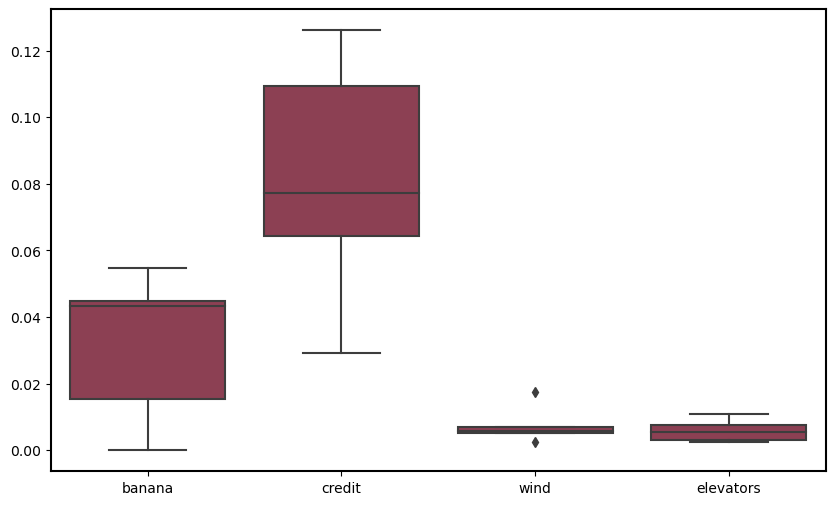

In [ ]:
plt.figure(figsize=(10, 6))

sns.boxplot(df, color = color)#,fill=False)
plt.grid(False) 

#plt.savefig('plots/svmmm_boxplot.pdf', transparent=True)
#plt.close()